<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Timeseries_ML_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Exercise:** `Time Series (ARIMA)`



**Study case:** the `AirPassengers dataset`

1. Perform EDA.
2. Check whether the data is stationary. If not, perform differencing.
3. Use the ADF test to statistically check the stationarity of the data.
4. Find the best ARIMA model using the ACF & PACF graphs.
5. Create the model and forecast for a 1-year period.

### **Initial Setup**

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

### **Data Understanding**

- The dataset depicts the number of passengers per month from 1949 to 1960.
- Each row represents information about the number of passengers.

In [2]:
# Loading dataset
url = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/AirPassengers.csv'
data = pd.read_csv(url)
data.head()

,TravelDate,Passengers
0,1/1/1949,112
1,2/1/1949,118
2,3/1/1949,132
3,4/1/1949,129
4,5/1/1949,121


In [3]:
# dimension # rows and columns
data.shape

(144, 2)

In [4]:
# Change the data type from object to datetime
data['TravelDate'] = pd.to_datetime(data['TravelDate'])

# Add a year column
data['Year'] = data['TravelDate'].dt.year
data['TravelDate'] = data['TravelDate'].dt.date
data.head()

,TravelDate,Passengers,Year
0,1949-01-01,112,1949
1,1949-02-01,118,1949
2,1949-03-01,132,1949
3,1949-04-01,129,1949
4,1949-05-01,121,1949


**Initial Assesment**

In [5]:
# Check data type, null values, and unique values ​​of each column
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'null': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,sample_unique
0,TravelDate,object,0.0,False,144,"[1949-01-01, 1949-02-01, 1949-03-01, 1949-04-0..."
1,Passengers,int64,0.0,False,118,"[112, 118, 132, 129, 121, 135, 148, 136, 119, ..."
2,Year,int32,0.0,False,12,"[1949, 1950, 1951, 1952, 1953, 1954, 1955, 195..."


**Descriptive Statistics**

In [6]:
data.describe()

,Passengers,Year
count,144.000000,144.000000
mean,280.298611,1954.500000
std,119.966317,3.464102
min,104.000000,1949.000000
25%,180.000000,1951.750000
50%,265.500000,1954.500000
75%,360.500000,1957.250000
max,622.000000,1960.000000


### **Exploratory Data Analysis (EDA)**

`Histogram`

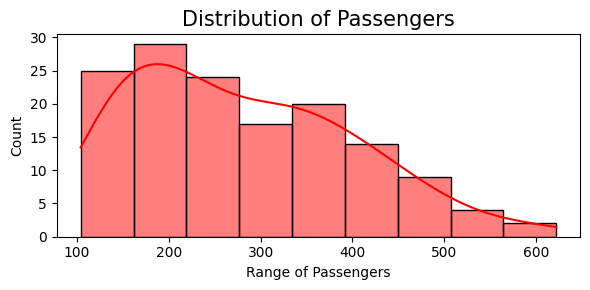

In [7]:
plt.figure(figsize=(6, 3))

sns.histplot(data['Passengers'], kde=True, color='red')
plt.title(f'Distribution of Passengers', fontsize = 15)
plt.xlabel(f'Range of Passengers')
plt.ylabel('Count')

plt.tight_layout()

`Boxplot`

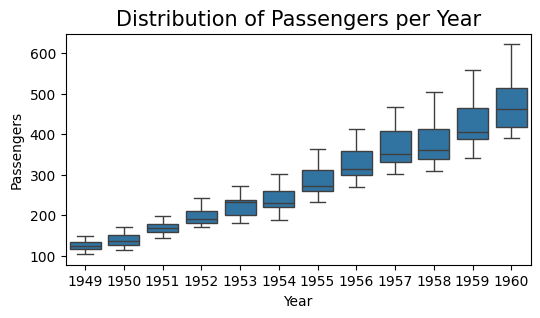

In [8]:
plt.subplots(figsize=(6,3))
sns.boxplot(x=data['Year'], y=data['Passengers'])
plt.title(f'Distribution of Passengers per Year', fontsize = 15)
plt.show()

`Lineplot`

In [9]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(name='true', x=data['TravelDate'], y=data['Passengers'])])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### **Check Stationarity**

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Passengers'])
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]}')
print("Critical Value")
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

alpha = 0.05

if result[1] <= alpha:
    print('Reject null hypothesis, The data is stationary')
else:
    print('Failed to reject null hypothesis, The data is not stationary')

ADF Statistic: 0.815
p-value: 0.991880243437641
Critical Value
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to reject null hypothesis, The data is not stationary


- The initial dataset is not stationary, so it cannot be used for ARIMA modeling.
- Differentiation must be performed first to ensure it is stationary.

### **Making Time Series Stationary**

`1st Order Differencing`

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Passengers'].diff(1).dropna())
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]}')
print("Critical Value")
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

alpha = 0.05

if result[1] <= alpha:
    print('Reject null hypothesis, The data is stationary')
else:
    print('Failed to reject null hypothesis, The data is not stationary')

ADF Statistic: -2.829
p-value: 0.05421329028382478
Critical Value
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to reject null hypothesis, The data is not stationary


`2nd Order Differencing`

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Passengers'].diff(1).diff(1).dropna())
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]}')
print("Critical Value")
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

alpha = 0.05

if result[1] <= alpha:
    print('Reject null hypothesis, The data is stationary')
else:
    print('Failed to reject null hypothesis, The data is not stationary')

ADF Statistic: -16.384
p-value: 2.7328918500142026e-29
Critical Value
	1%: -3.482
	5%: -2.884
	10%: -2.579
Reject null hypothesis, The data is stationary


The data is stationary after 2 differencing.

### **Observations Based on ACF/PACF Plot**

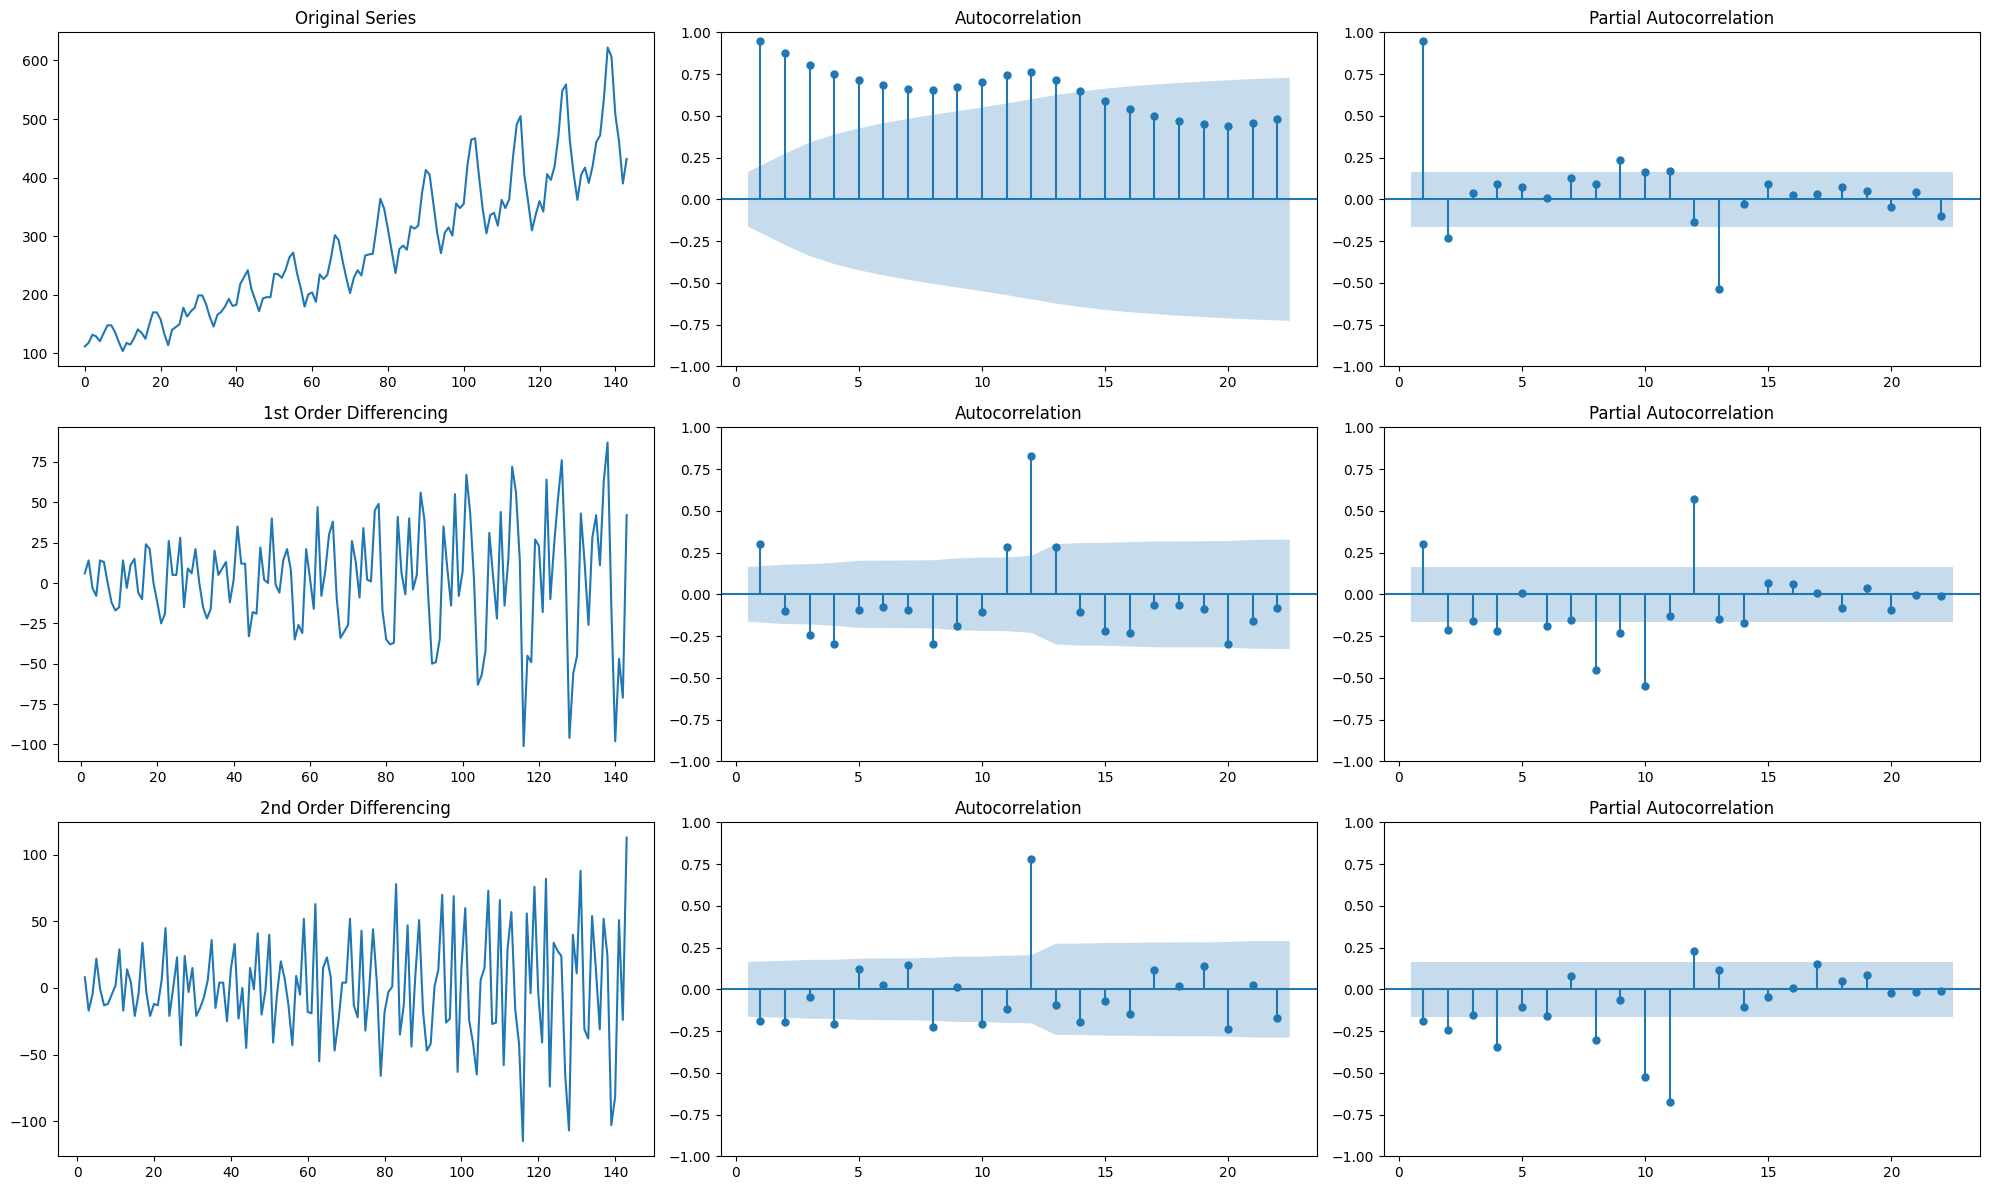

In [13]:
fig, axes = plt.subplots(3, 3, figsize = (20,12))

# Original Series
axes[0, 0].plot(data['Passengers']);
axes[0, 0].set_title('Original Series')
plot_acf(data['Passengers'], ax=axes[0, 1], zero = False)
plot_pacf(data['Passengers'], ax=axes[0, 2], zero = False, method='ywm')

# 1st Differencing
axes[1, 0].plot(data['Passengers'].diff(1));
axes[1, 0].set_title('1st Order Differencing')
plot_acf(data['Passengers'].diff(1).dropna(), ax=axes[1, 1], zero = False)
plot_pacf(data['Passengers'].diff(1).dropna(), ax=axes[1, 2], zero = False, method='ywm')

# 2nd Differencing
axes[2, 0].plot(data['Passengers'].diff(1).diff(1));
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data['Passengers'].diff(1).diff(1).dropna(), ax=axes[2, 1], zero = False)
plot_pacf(data['Passengers'].diff(1).diff(1).dropna(), ax=axes[2, 2], zero = False, method='ywm')

plt.tight_layout()
plt.show()

**Interpretation**

- In the original series, the ACF (Autocorrelation) graph is still slowly decaying. This means the data is not stationary.
- We perform first-order differencing.
- Judging from the ACF (Autocorrelation) graph, which is no longer slowly decaying, the data is stationary at first-order differencing. However, the linechart shows that the mean is stationary, but the variance is still not stationary.
- Let's try performing second-order differencing.
- From the graph, the data appears to be stationary. This aligns well with the results of the Adfuller test.

### **Modeling**

- ARIMA model determination can be done manually by looking at the ACF and PACF graphs above. The determination is subjective.
- Judging from the graph, the data is stationary at second-order differencing. This means d = 2.
- Look at the ACF graph. The first bar outside the blue zone (confidence interval) is chosen as q (MA). This means q = 12.
- Look at the PACF graph. The first bar outside the blue zone (confidence interval) is chosen as p (AR). This means p = 13.

The ACF graph is cut-off, and the PACF graph is also cut-off. So the candidates are:
- ARIMA (p, d, q) = (13, 2, 0)
- ARIMA (p, d, q) = (0, 2, 12)

We can also find the best ARIMA model using loops. The smallest AIC value indicates the best model.

In [14]:
def get_aic(data, p, d, q) :

    # define model
    model = ARIMA(data, order=(p,d,q))

    # fit
    result = model.fit()

    # AIC score
    score = result.aic
    return score

`Data Splitting`

In [15]:
train = data[data['Year'] < 1958]
test = data[data['Year'] >= 1958]

`Model Benchmarking`

In [16]:
model_names = []
scores = []

for p in range(1,21) :
    model_names.append((f'ARIMA({p},2,0)'))
    scores.append(get_aic(train['Passengers'], p, 2, 0))

for q in range(1,21) :
    model_names.append((f'ARIMA(0,2,{q})'))
    scores.append(get_aic(train['Passengers'], 0, 2, q))

In [17]:
pd.DataFrame({
    'model' : model_names,
    'AIC' : scores
}).sort_values('AIC').head(5)

,model,AIC
11,"ARIMA(12,2,0)",822.489518
17,"ARIMA(18,2,0)",824.926467
18,"ARIMA(19,2,0)",826.585519
10,"ARIMA(11,2,0)",827.369935
13,"ARIMA(14,2,0)",828.468443


Based on the data above, the best model with the lowest AIC is ARIMA (12, 2, 0)

In [18]:
# define model
best_arima = ARIMA(train['Passengers'], order=(12,2,0))

# fit
best_model = best_arima.fit()

`Forecast to Test Set`

In [19]:
# how many months in the future
forecast_length = 36

# forecast (predict)
forecast_result = best_model.forecast(forecast_length)

# forecast period
forecast_period = data['TravelDate'].iloc[-36:]

In [20]:
df_forecast = pd.DataFrame({
    'TravelDate': forecast_period,
    'Passengers': forecast_result
})

In [21]:
import plotly.graph_objects as go

# title
my_layout = go.Layout(
    title='Number of Passengers',
    title_x= 0.5,
    # margin=dict(l=100, r=100, t=100, b=100),
    width=900,
    height=450,
)

fig = go.Figure(layout= my_layout)

# original data
fig.add_trace(go.Scatter(x=data['TravelDate'], y=data['Passengers'], name='Original'))

# forecast result
fig.add_trace(go.Scatter(x=df_forecast['TravelDate'], y=df_forecast['Passengers'], name='Forecast'))

fig.show()

`Model Evaluation`

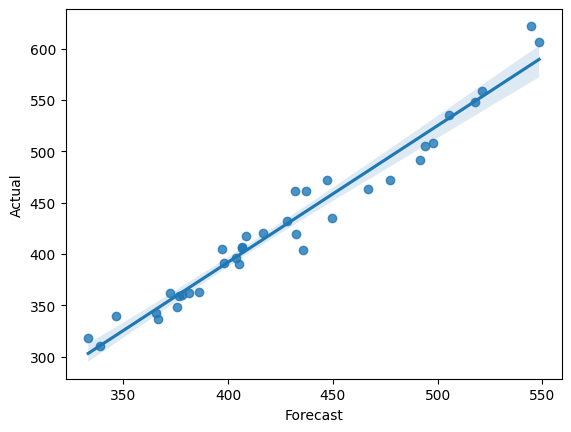

In [22]:
sns.regplot(x=forecast_result, y=data['Passengers'].iloc[-36:])
plt.xlabel('Forecast')
plt.ylabel('Actual')
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test['Passengers'], forecast_result)

0.04302319580440869

It can be seen that the forecast and actual results are not that different (MAPE=4.3%), so we can use the ARIMA(12,2,0) model as the best model.

### **Final Model**

In [24]:
# define model
final_arima = ARIMA(data['Passengers'], order=(12,2,0))

# fit
final_model = final_arima.fit()

In [27]:
# How many months into the future?
forecast_length = 12

# forecast (predict)
forecast_result = final_model.forecast(forecast_length)

# Create list of months
forecast_period = [f'1961-{months+1}-01' for months in range(forecast_length)]


In [28]:
data.iloc[-1:,:-1]

,TravelDate,Passengers
143,1960-12-01,432


In [29]:
df_forecast = pd.DataFrame({
    'TravelDate': forecast_period,
    'Passengers': forecast_result
})

df_forecast = pd.concat([data.iloc[-1:,:-1], df_forecast])

In [30]:
import plotly.graph_objects as go

# Judul
my_layout = go.Layout(
    title='Number of Passengers',
    title_x= 0.5,
    # margin=dict(l=100, r=100, t=100, b=100),
    width=900,
    height=450,
)

fig = go.Figure(layout= my_layout)

# data original
fig.add_trace(go.Scatter(x=data['TravelDate'], y=data['Passengers'], name='Original'))

# hasil forecast
fig.add_trace(go.Scatter(x=df_forecast['TravelDate'], y=df_forecast['Passengers'], name='Forecast'))

fig.show()

Additional Time series ML tutorial: `Prophet`

- [Prophet](https://facebook.github.io/prophet/) is open source software released by Facebook's Core Data Science team.
- Prophet is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.
- It works best with time series that have strong seasonal effects and several seasons of historical data.
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- The Prophet package provides intuitive parameters which are easy to tune.

**Trend parameters**

- growth: 'linear' or 'logistic' to specify a linear or logistic trend
- changepoints:	List of dates at which to include potential changepoints (automatic if not specified)
- n_changepoints: If changepoints in not supplied, you may provide the number of changepoints to be automatically included
- changepoint_prior_scale: Parameter for changing flexibility of automatic changepoint selection


**Seasonality and Holiday Parameters**

- yearly_seasonality: Fit yearly seasonality
- weekly_seasonality: Fit weekly seasonality
- daily_seasonality: Fit daily seasonality
- holidays: Feed dataframe containing holiday name and date
- seasonality_prior_scale: Parameter for changing strength of seasonality model
- holiday_prior_scale: Parameter for changing strength of holiday model

Prophet requires the variable names in the time series to be:

- y – Target
- ds – Datetime

In [32]:
# Creating dataframe
train_prophet = pd.DataFrame()
train_prophet['ds'] = train['TravelDate']
train_prophet['y'] = train['Passengers']
train_prophet.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [33]:
from prophet import Prophet

# instantiate Prophet with only yearly seasonality as our data is monthly
model = Prophet( yearly_seasonality=True, seasonality_mode = 'multiplicative')

# fit the model with your dataframe
model.fit(train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp19iu6gx8/wpa30wd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp19iu6gx8/vwnqqwpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94560', 'data', 'file=/tmp/tmp19iu6gx8/wpa30wd9.json', 'init=/tmp/tmp19iu6gx8/vwnqqwpb.json', 'output', 'file=/tmp/tmp19iu6gx8/prophet_model87524tzl/prophet_model-20250926005840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:58:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:58:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [34]:
# predict for 36 months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 36, freq = 'MS')
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,118.733816,100.261990,118.198829,118.733816,118.733816,-0.089425,-0.089425,-0.089425,-0.089425,-0.089425,-0.089425,0.0,0.0,0.0,108.116013
1,1949-02-01,120.041508,95.708912,113.915048,120.041508,120.041508,-0.125162,-0.125162,-0.125162,-0.125162,-0.125162,-0.125162,0.0,0.0,0.0,105.016842
2,1949-03-01,121.222649,114.411261,132.576160,121.222649,121.222649,0.019777,0.019777,0.019777,0.019777,0.019777,0.019777,0.0,0.0,0.0,123.620122
3,1949-04-01,122.530341,111.391430,129.177564,122.530341,122.530341,-0.015889,-0.015889,-0.015889,-0.015889,-0.015889,-0.015889,0.0,0.0,0.0,120.583412
4,1949-05-01,123.795849,112.762243,130.131740,123.795849,123.795849,-0.019192,-0.019192,-0.019192,-0.019192,-0.019192,-0.019192,0.0,0.0,0.0,121.419997


In [35]:
data_prophet = pd.DataFrame()
data_prophet['ds'] = data['TravelDate']
data_prophet['y'] = data['Passengers']
data_prophet.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


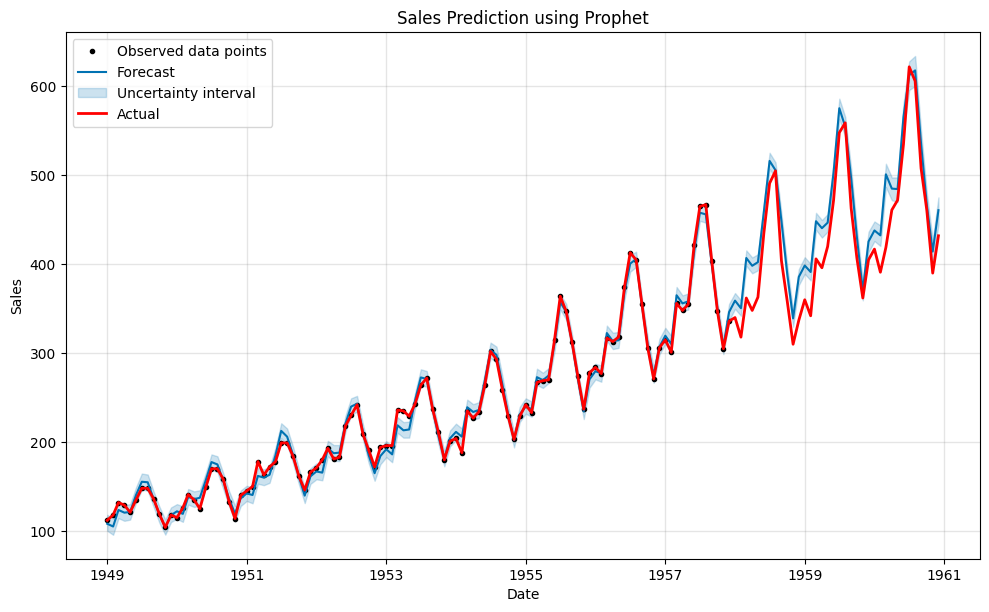

In [36]:
# visualizations
fig = model.plot(forecast)
sns.lineplot(data=data_prophet, x='ds', y='y', label='Actual', color = 'red', linewidth = 2)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Prediction using Prophet')
plt.show()

In [37]:
# Check MAPE between test data and forecast results
mean_absolute_percentage_error(test['Passengers'], forecast['yhat'].iloc[-36:])

0.07382011140886219

It can be seen that between the forecast and actual results using Prophet, the MAPE is 7.5%, it turns out that the ARIMA(12,2,0) model gives better results.